In [ ]:
#unix time from each day of each month taken from: https://www.unixtimestamp.com/

#2023
#jun: 1685574000 AND 1688165999
#jul: 1688166000 AND 1690844399
#ago: 1690844400 AND 1693522799
#set: 1693522800 AND 1696114799
#out: 1696114800 AND 1698796799
#nov: 1698796800 AND 1701388799
#dez: 1701388800 AND 1704067199

#2024
#jan: 1704067200 AND 1706745599
#feb: 1706745600 AND 1709251199
#mar: 1709251200 AND 1711925999
#abr: 1711926000 AND 1714517999
#mai: 1714518000 AND 1717196399
#jun: 1717196400 AND 1719788399
#jul: 1719788400 AND 1722466799
#ago: 1722466800 AND 1725145199
#set: 1725145200 AND 1727737199
#out: 1727737200 AND 1730419199
#nov: 1730419200 AND 1733011199
#dez: 1733011200 AND 1735689599

#2025
#jan: 1735689600 AND 1738367999
#feb: 1738368000 AND 1740787199
#mar: 1740787200 AND 1743461999
#abr: 1743462000 AND 1746053999
#mai: 1746054000 AND 1748732399
#jun: 1748732400 AND 1751324399
#jul: 1751324400 AND 1754002799
#ago: 1754002800 AND 1756681199

#collumns from state vector data: callsign, lat, lon, velocity, vertrate, heading, baroaltitude
#for more information about open sky's historical data and performance guidelines: https://opensky-network.org/data/trino

#### opensky data

In [ ]:
#query used to retrieve information from each day

from pyopensky.trino import Trino
import pandas as pd

opensky = Trino()

query = """
SELECT time, icao24, callsign, lat, lon, velocity, vertrate, heading, baroaltitude
FROM state_vectors_data4
WHERE hour BETWEEN 1756594800 AND 1756681199
  AND lat BETWEEN 38.0 AND 39.0
  AND lon BETWEEN -10.0 AND -9.0
  AND baroaltitude <= 2000
  AND velocity IS NOT NULL
  AND baroaltitude IS NOT NULL
  AND lat IS NOT NULL
  AND lon IS NOT NULL
  AND vertrate IS NOT NULL
  AND heading IS NOT NULL
  AND callsign IS NOT NULL
  AND onground = FALSE 
"""

df = opensky.query(query)
df.to_csv("ago31.csv", index=False) 

No credentials provided, falling back to browser authentication


Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/d9ffe648a234736984a275022757d32946bf058c141e12aae3c395350e1dd10c


RUNNING: : 61.7% [00:02, 20.7%/s]
DOWNLOAD: 335klines [00:08, 38.3klines/s]


In [ ]:
#merge all days into a dataset 

import pandas as pd
import glob
 
file_paths = sorted(glob.glob("*.csv"))

df = pd.concat((pd.read_csv(f) for f in file_paths), ignore_index=True)
df.to_csv("opensky_abr24_data.csv", index=False)

#### ga

In [ ]:
#query used to retrieve information about a go around

from pyopensky.trino import Trino
import pandas as pd

opensky = Trino()

query = """
SELECT time, icao24, callsign, baroaltitude, velocity, vertrate, lat, lon
FROM state_vectors_data4
WHERE time BETWEEN 1735161000 AND 1735162200
  AND lat BETWEEN 38.0 AND 39.0
  AND lon BETWEEN -10.0 AND -9.0
  AND icao24 = '440daf'
"""

df = opensky.query(query)
df.to_csv("ga_dez.csv", index=False) 

No credentials provided, falling back to browser authentication


Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/e6667e5bae82fb80d5aceab54443d4cd3efa9179aa0baeec4f20de0fdb10707f


FINISHED: : 99.6% [00:28, 3.50%/s]
DOWNLOAD: 1.20klines [00:00, 133klines/s]


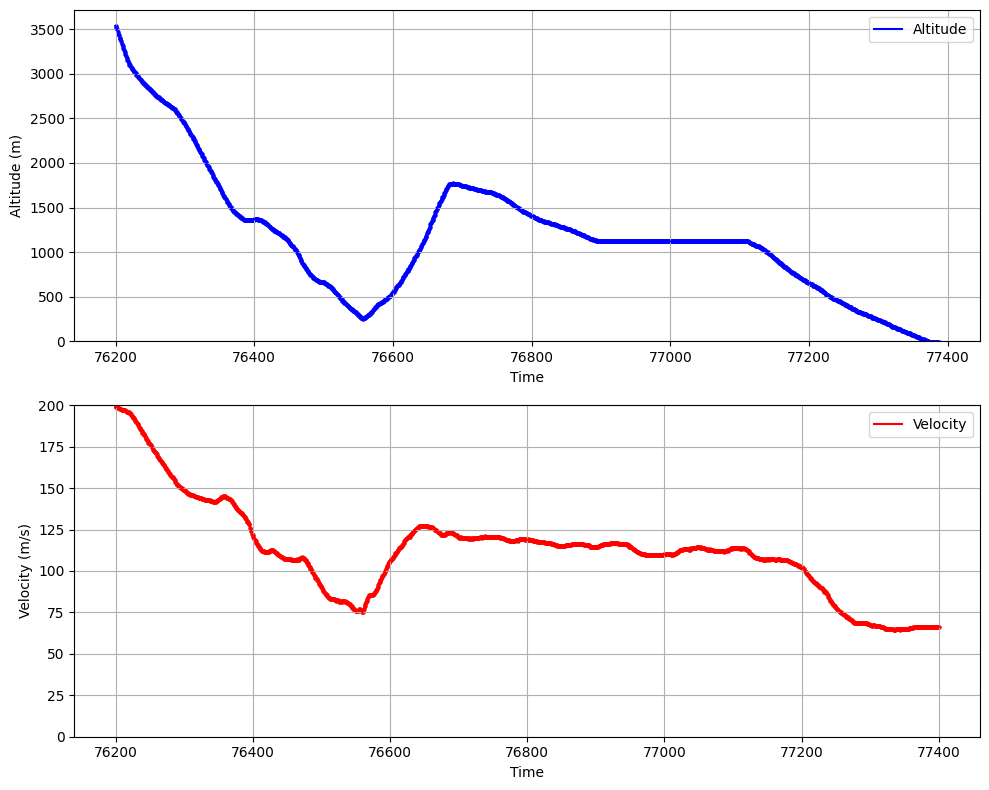

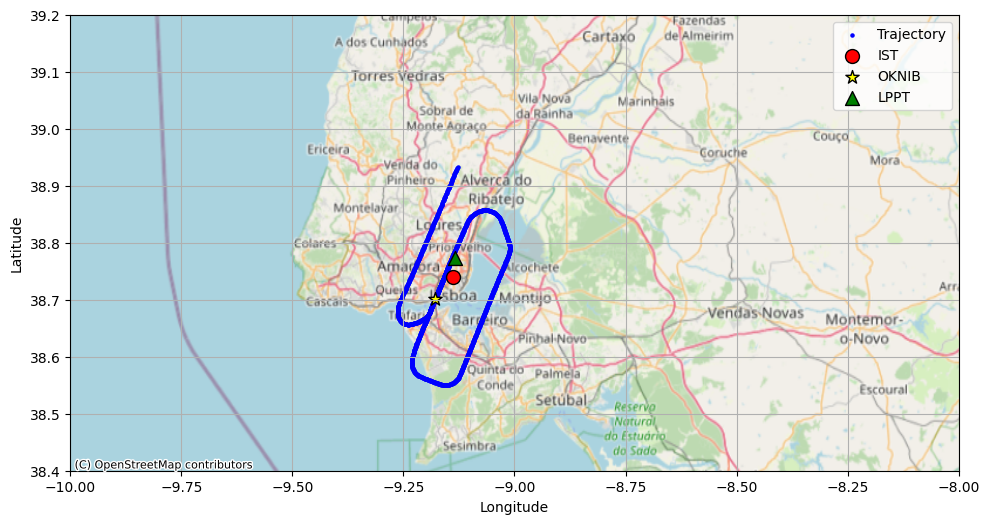

In [ ]:
#plots: altitude vs time, speed vs time and trajectory

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

oknib_lon, oknib_lat = -9.17861111, 38.70222222
lis_lon, lis_lat = -9.134167, 38.774167
ist_lon, ist_lat = -9.137961014549424, 38.73990015557909

df['datetime'] = pd.to_datetime(df['time'], unit='s')
df['Time_Sec'] = df['datetime'].dt.hour * 3600 + df['datetime'].dt.minute * 60 + df['datetime'].dt.second

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(df['Time_Sec'], df['baroaltitude'], 'b-', label="Altitude")
axes[0].scatter(df['Time_Sec'], df['baroaltitude'], c='blue', s=5)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Altitude (m)')
axes[0].set_ylim(0, )
axes[0].grid(True)
axes[0].legend()

axes[1].plot(df['Time_Sec'], df['velocity'], 'r-', label="Velocity")
axes[1].scatter(df['Time_Sec'], df['velocity'], c='red', s=5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_ylim(0, 200)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))

gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])],
    crs="EPSG:4326"
)

gdf.plot(ax=ax, color='blue', linewidth=1, marker='o', markersize=5, label="Trajectory")

ax.scatter(ist_lon, ist_lat, color='red', s=100, edgecolor='black', label="IST")
ax.scatter(oknib_lon, oknib_lat, color='yellow', marker='*', s=100, edgecolor='black', label="OKNIB")
ax.scatter(lis_lon, lis_lat, color='green', marker='^', s=100, edgecolor='black', label="LPPT")

ax.set_xlim(-10.0, -8.0)
ax.set_ylim(38.4, 39.2)

ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

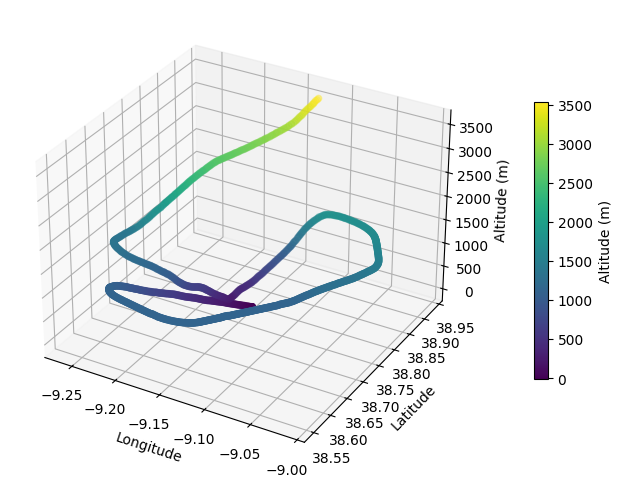

In [ ]:
#plot: 3d trajectory

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

x = df['lon'].values
y = df['lat'].values
z = df['baroaltitude'].values
c = z  

sc = ax.scatter(x, y, z, c=c, cmap="viridis", s=20)

cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Altitude (m)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Altitude (m)")

plt.show()

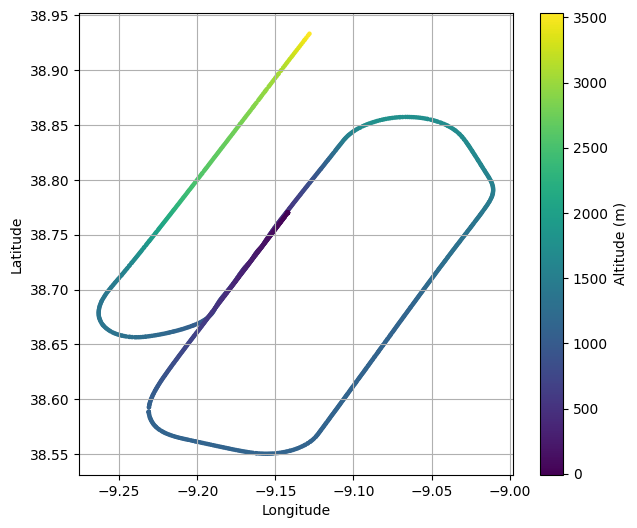

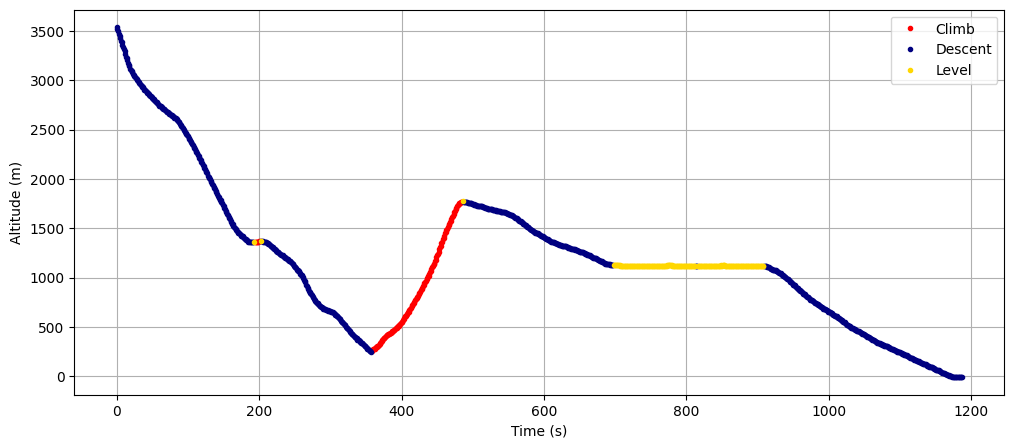

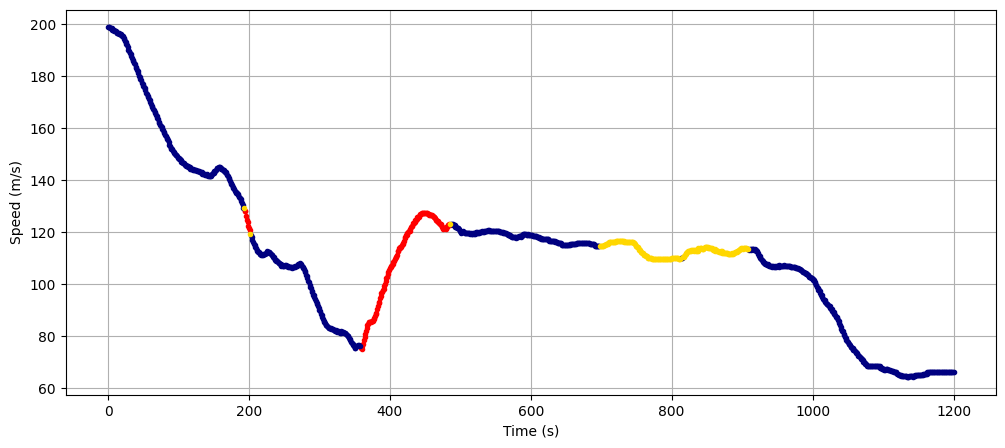

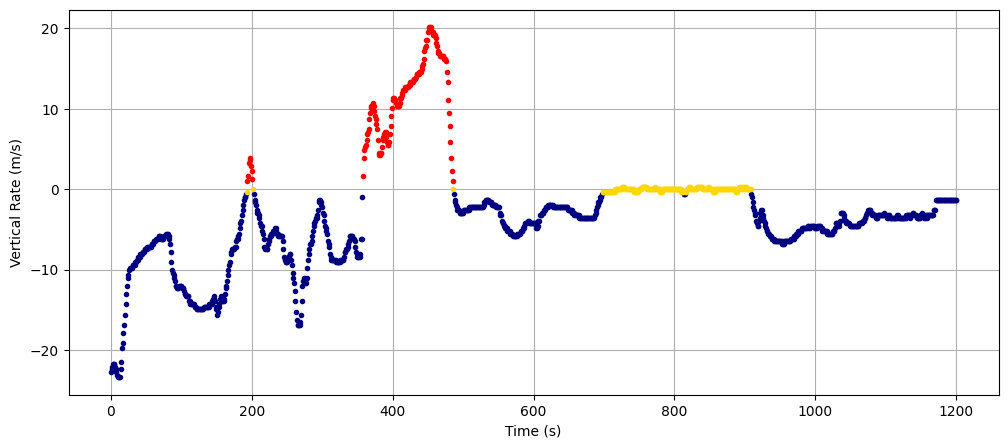

In [ ]:
#plots: trajectory, altitude vs time, speed vs time and vertical rate vs time with flight phases

import pandas as pd
import matplotlib.pyplot as plt

flight = df.sort_values("Time_Sec")

def classify_phase(vr):
    if vr > 0.5:
        return "Climb"
    elif vr < -0.5:
        return "Descent"
    else:
        return "Level"

flight["Phase"] = flight["vertrate"].apply(classify_phase)
phase_colors = {"Climb": "red", "Descent": "navy", "Level": "gold"}
flight["Time"] = flight["Time_Sec"] - flight["Time_Sec"].iloc[0] 

#Trajectory
plt.figure(figsize=(7,6)) 
sc = plt.scatter(flight["lon"], flight["lat"], c=flight["baroaltitude"], cmap="viridis", s=5)
plt.colorbar(sc, label="Altitude (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

#Altitude vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["baroaltitude"], ".", color=phase_colors[phase], label=phase)
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.legend()
plt.show()

#Speed vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["velocity"], ".", color=phase_colors[phase])
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
#plt.legend()
plt.show()

#Vertical rate vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["vertrate"], ".", color=phase_colors[phase])
plt.xlabel("Time (s)")
plt.ylabel("Vertical Rate (m/s)")
plt.grid(True)
#plt.legend()
plt.show()

#### normal landing

In [ ]:
#query used to retrieve information about a normal landing

from pyopensky.trino import Trino
import pandas as pd

opensky = Trino()

query = """
SELECT time, icao24, callsign, baroaltitude, velocity, vertrate, lat, lon
FROM state_vectors_data4
WHERE time BETWEEN 1734039000 AND 1734040200
  AND lat BETWEEN 38.0 AND 39.0
  AND lon BETWEEN -10.0 AND -9.0
  AND icao24 = '01010c'
"""

normal_df = opensky.query(query)
normal_df.to_csv("normal_dez.csv", index=False) 

No credentials provided, falling back to browser authentication


Open the following URL in browser for the external authentication:
https://trino.opensky-network.org/oauth2/token/initiate/9a75441e1fd4b4ffa8730f4e9ec6ca01fe81f4658a2149c478ff9cb9deaee7e7


FINISHED: : 99.9% [00:30, 3.28%/s]
DOWNLOAD: 1.07klines [00:00, 177klines/s]


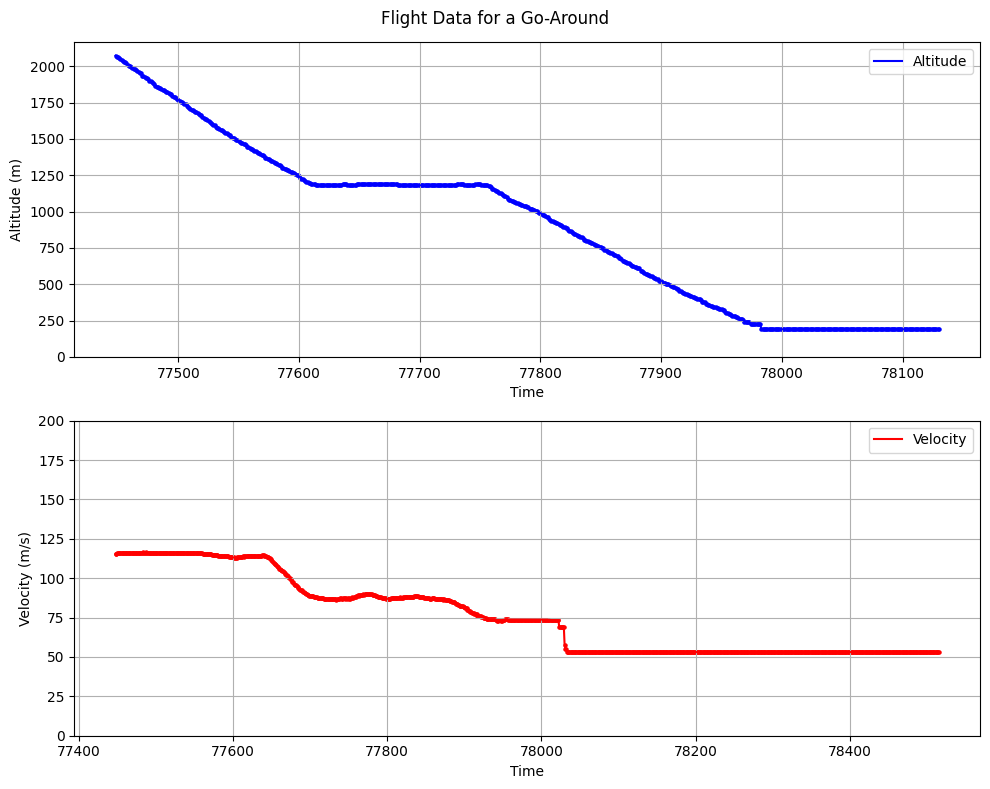

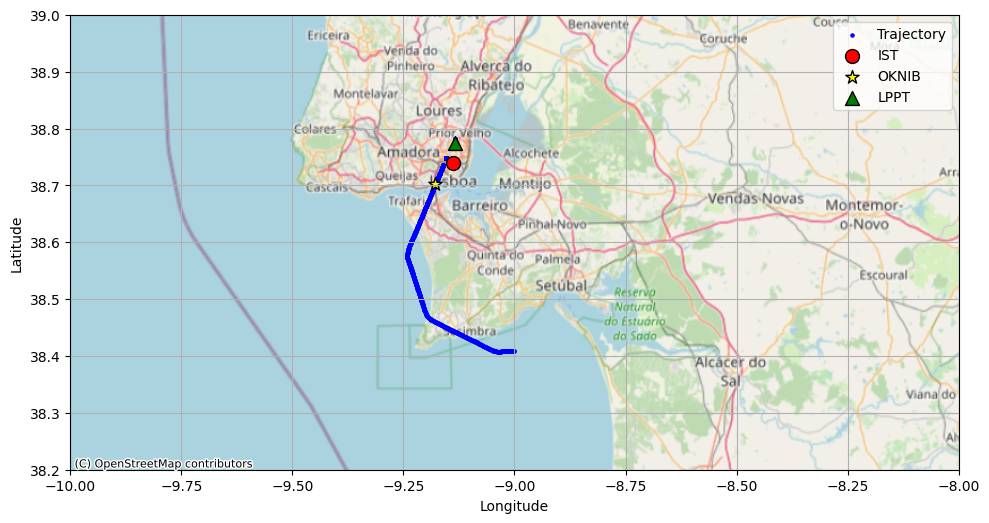

In [ ]:
#plots: altitude vs time, speed vs time and trajectory

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

oknib_lon, oknib_lat = -9.17861111, 38.70222222
lis_lon, lis_lat = -9.134167, 38.774167
ist_lon, ist_lat = -9.137961014549424, 38.73990015557909

normal_df['datetime'] = pd.to_datetime(normal_df['time'], unit='s')
normal_df['Time_Sec'] = normal_df['datetime'].dt.hour * 3600 + normal_df['datetime'].dt.minute * 60 + normal_df['datetime'].dt.second

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(normal_df['Time_Sec'], normal_df['baroaltitude'], 'b-', label="Altitude")
axes[0].scatter(normal_df['Time_Sec'], normal_df['baroaltitude'], c='blue', s=5)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Altitude (m)')
axes[0].set_ylim(0, )
axes[0].grid(True)
axes[0].legend()

axes[1].plot(normal_df['Time_Sec'], normal_df['velocity'], 'r-', label="Velocity")
axes[1].scatter(normal_df['Time_Sec'], normal_df['velocity'], c='red', s=5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_ylim(0, 200)
axes[1].grid(True)
axes[1].legend()

plt.suptitle(f"Flight Data for a Go-Around")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))

gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(normal_df['lon'], normal_df['lat'])],
    crs="EPSG:4326"
)

gdf.plot(ax=ax, color='blue', linewidth=1, marker='o', markersize=5, label="Trajectory")

ax.scatter(ist_lon, ist_lat, color='red', s=100, edgecolor='black', label="IST")
ax.scatter(oknib_lon, oknib_lat, color='yellow', marker='*', s=100, edgecolor='black', label="OKNIB")
ax.scatter(lis_lon, lis_lat, color='green', marker='^', s=100, edgecolor='black', label="LPPT")

ax.set_xlim(-10.0, -8.0)
ax.set_ylim(38.2, 39.0)

ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

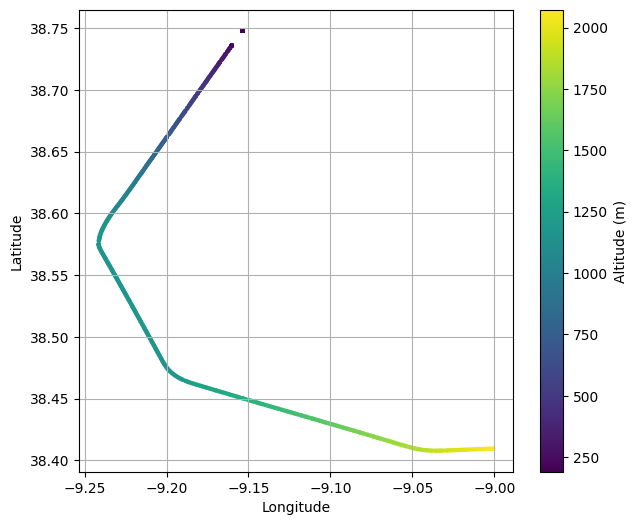

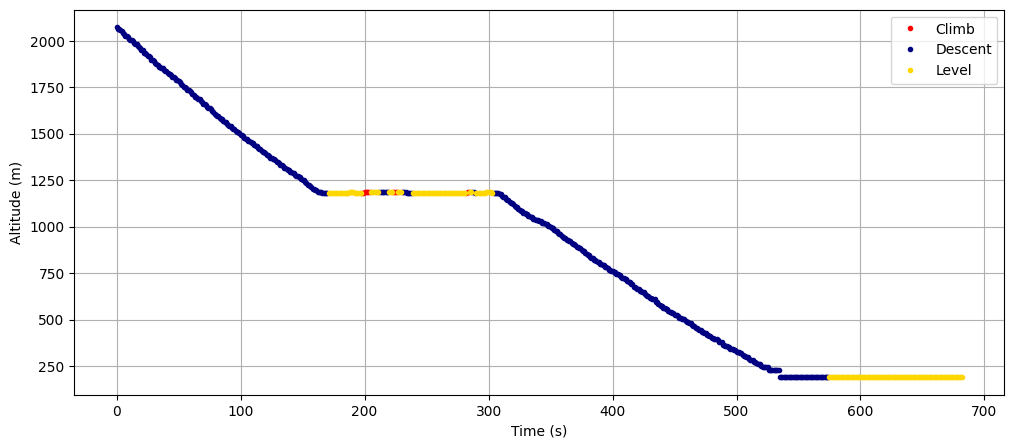

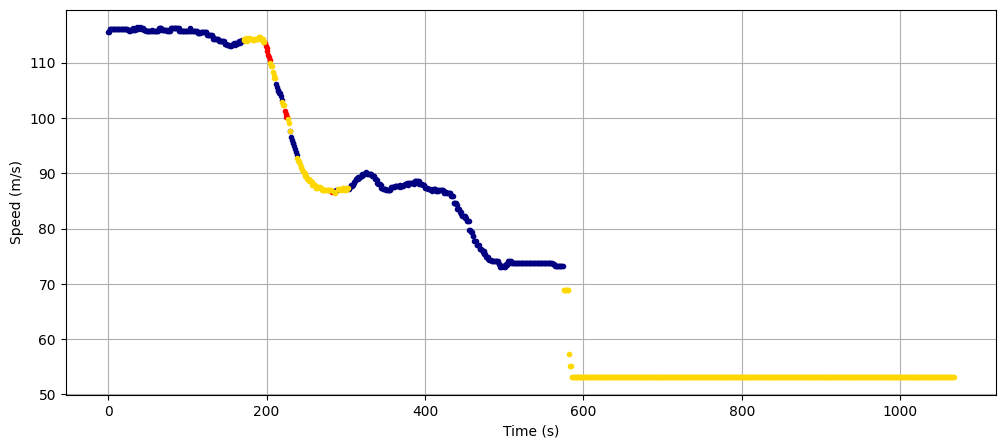

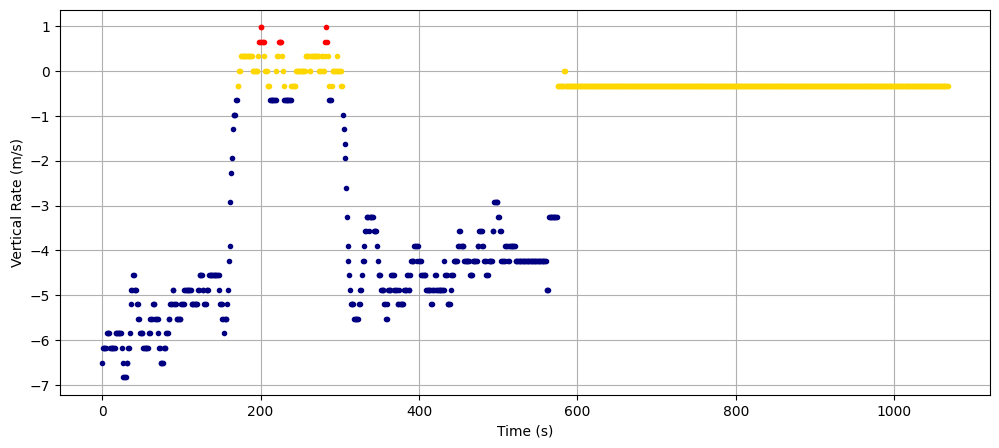

In [ ]:
#plots: trajectory, altitude vs time, speed vs time and vertical rate vs time with flight phases

import pandas as pd
import matplotlib.pyplot as plt

flight = normal_df.sort_values("Time_Sec")

def classify_phase(vr):
    if vr > 0.5:
        return "Climb"
    elif vr < -0.5:
        return "Descent"
    else:
        return "Level"

flight["Phase"] = flight["vertrate"].apply(classify_phase)
phase_colors = {"Climb": "red", "Descent": "navy", "Level": "gold"}
flight["Time"] = flight["Time_Sec"] - flight["Time_Sec"].iloc[0] 

#Trajectory
plt.figure(figsize=(7,6)) 
sc = plt.scatter(flight["lon"], flight["lat"], c=flight["baroaltitude"], cmap="viridis", s=5)
plt.colorbar(sc, label="Altitude (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

#Altitude vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["baroaltitude"], ".", color=phase_colors[phase], label=phase)
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.legend()
plt.show()

#Speed vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["velocity"], ".", color=phase_colors[phase])
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid(True)
#plt.legend()
plt.show()

#Vertical rate vs Time
plt.figure(figsize=(12, 5))
for phase in ["Climb", "Descent", "Level"]:
    seg = flight[flight["Phase"] == phase]
    plt.plot(seg["Time"], seg["vertrate"], ".", color=phase_colors[phase])
plt.xlabel("Time (s)")
plt.ylabel("Vertical Rate (m/s)")
plt.grid(True)
#plt.legend()
plt.show()